# Heart Attack Prediction
Binary classification task of prediction of Heart Attack Risk. The labels indicate 1 = high risk and 0 = low risk.

## This notebook
Featuring:
- **Sklearn Pipelines**
- **Model ensemble**
- **Permutation importance**
- **Hyperparameter optimization (Optuna)**
- **Final model explicability using SHAP values**

### Description
The notebook starts by briefly exploring the data and splitting it into a train and a test set. Then both datasets are used for testing different models. The best architecture is then used to run a *permutation importance analysis* to assess the features' importances. The new classification pipeline is optimized using *Optuna*, retrained using the whole data and finally we analyse the model's predictions according to the input features' values using *SHAP values*. 

### Data location
The dataset can be found on [Kaggle](https://www.kaggle.com/datasets/rashikrahmanpritom/heart-attack-analysis-prediction-dataset/data)

# Main imports

In [1]:
import numpy as np
import pandas as pd
from copy import deepcopy

# Plotting and visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")
sns.set_context("notebook")

# Numerical preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# For creating pipelines
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer

# Data splitting and cross validation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, cross_validate

# Performance metrics
from sklearn.metrics import classification_report, accuracy_score

# Reading the data

In [2]:
df = pd.read_csv("heart.csv")
print(df.shape)
df.head()

(303, 14)


,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


## Checking for duplicates

In [3]:
print(df.shape)
df.drop_duplicates(keep="first",inplace=True)
df.reset_index(drop=True, inplace=True)
print(df.shape)

(303, 14)
(302, 14)


## Checking for missing values

In [4]:
df.isnull().sum()

age         0
sex         0
cp          0
trtbps      0
chol        0
fbs         0
restecg     0
thalachh    0
exng        0
oldpeak     0
slp         0
caa         0
thall       0
output      0
dtype: int64

# Feature engineering

In [5]:
# Age categories
df["age_group"] = pd.cut(df["age"], 
                         bins=[0, 30, 50, 70, np.inf],
                         labels=[0, 1, 2, 3]) # labels=["young", "middle-aged", "senior", "elderly"]

# Blood pressure categories
df["bp_category"] = pd.cut(df["trtbps"], 
                           bins=[0, 90, 120, 140, 200],
                           labels=[0, 1, 2, 3]) # labels=["low", "normal", "pre-high", "high"]

# Cholesterol to age ratio
df["chol_age_ratio"] = df["chol"] / df["age"]

# Cholesterol to resting blood pressure
df["chol_trtbps_ratio"] = df["chol"] / df["trtbps"]

# Chess pain and thallium stress association
df["cp_thall"] = df["cp"] * df["thall"]

# Age and resting blood pressure association
df["age_trtbps"] = df["age"] * df["trtbps"]

In [6]:
df.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output,age_group,bp_category,chol_age_ratio,chol_trtbps_ratio,cp_thall,age_trtbps
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1,2,3,3.698413,1.606897,3,9135
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1,1,2,6.756757,1.923077,4,4810
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1,1,2,4.975610,1.569231,2,5330
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1,2,1,4.214286,1.966667,2,6720
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1,2,1,6.210526,2.950000,0,6840


In [7]:
numerical_features = ["age", "trtbps", "chol", "thalachh", "oldpeak", "caa", "chol_age_ratio", "chol_trtbps_ratio", "cp_thall", "age_trtbps"]
nominal_features = ["sex", "fbs", "exng"]
ordinal_features = ["cp", "restecg", "slp", "thall", "age_group", "bp_category"]
target = "output"

# Exploratory analysis

## Numerical features

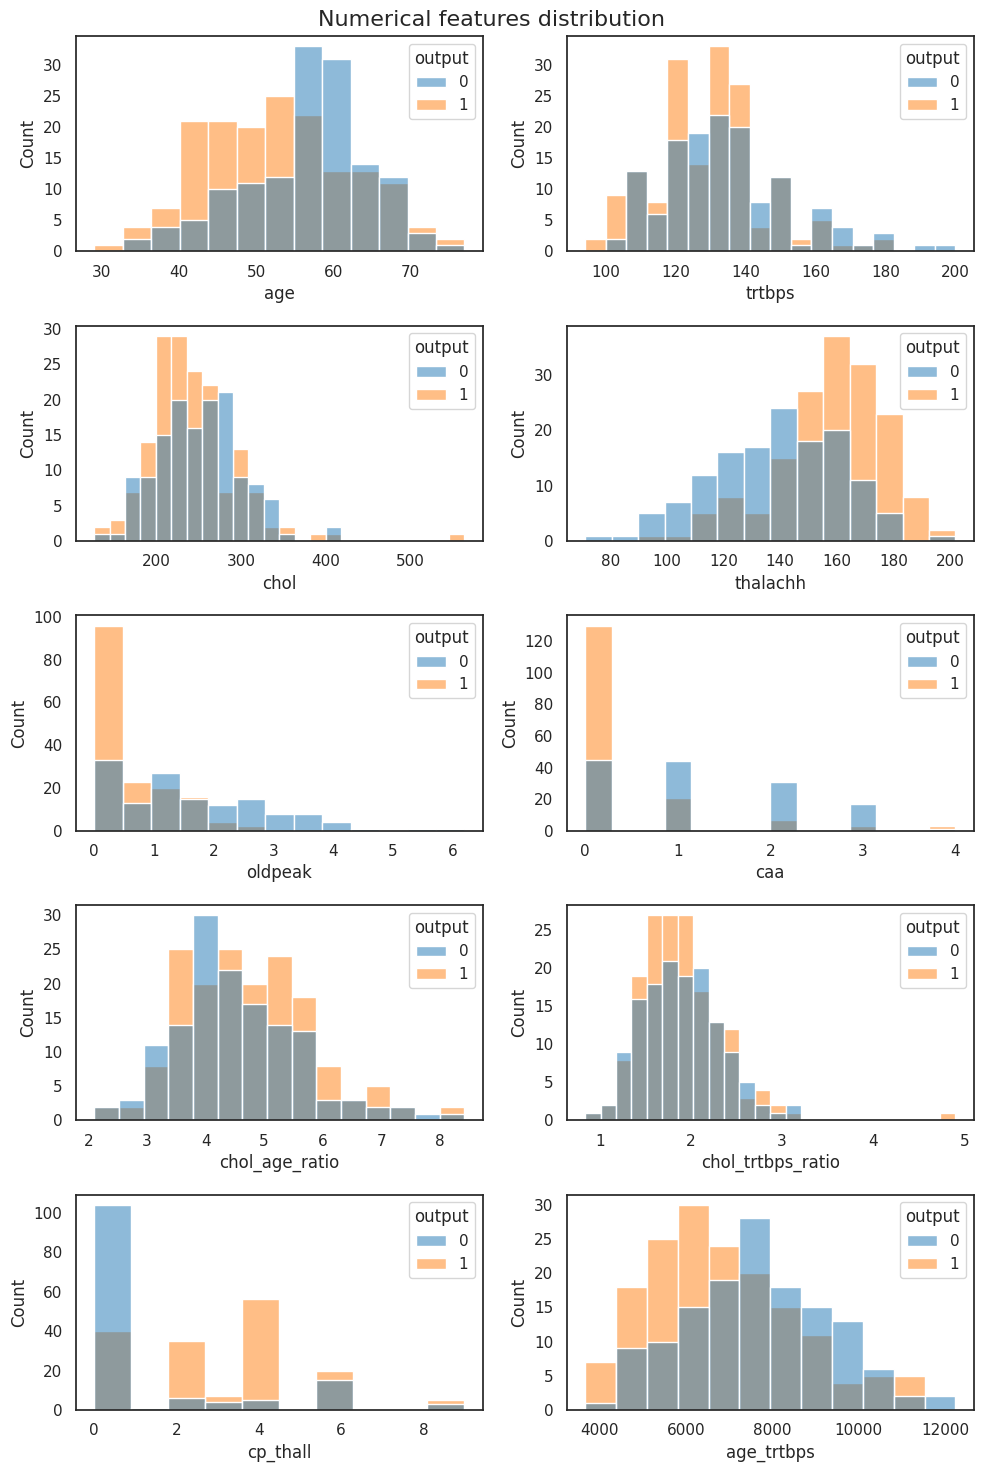

In [8]:
ncols = 2
nrows = int(np.ceil(len(numerical_features) / ncols))
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, nrows*3))
for feat, ax in zip(numerical_features, axes.flatten()):
    sns.histplot(df, x=feat, hue="output", ax=ax, stat="count")
fig.suptitle("Numerical features distribution", fontsize=16)
fig.tight_layout()
plt.show()

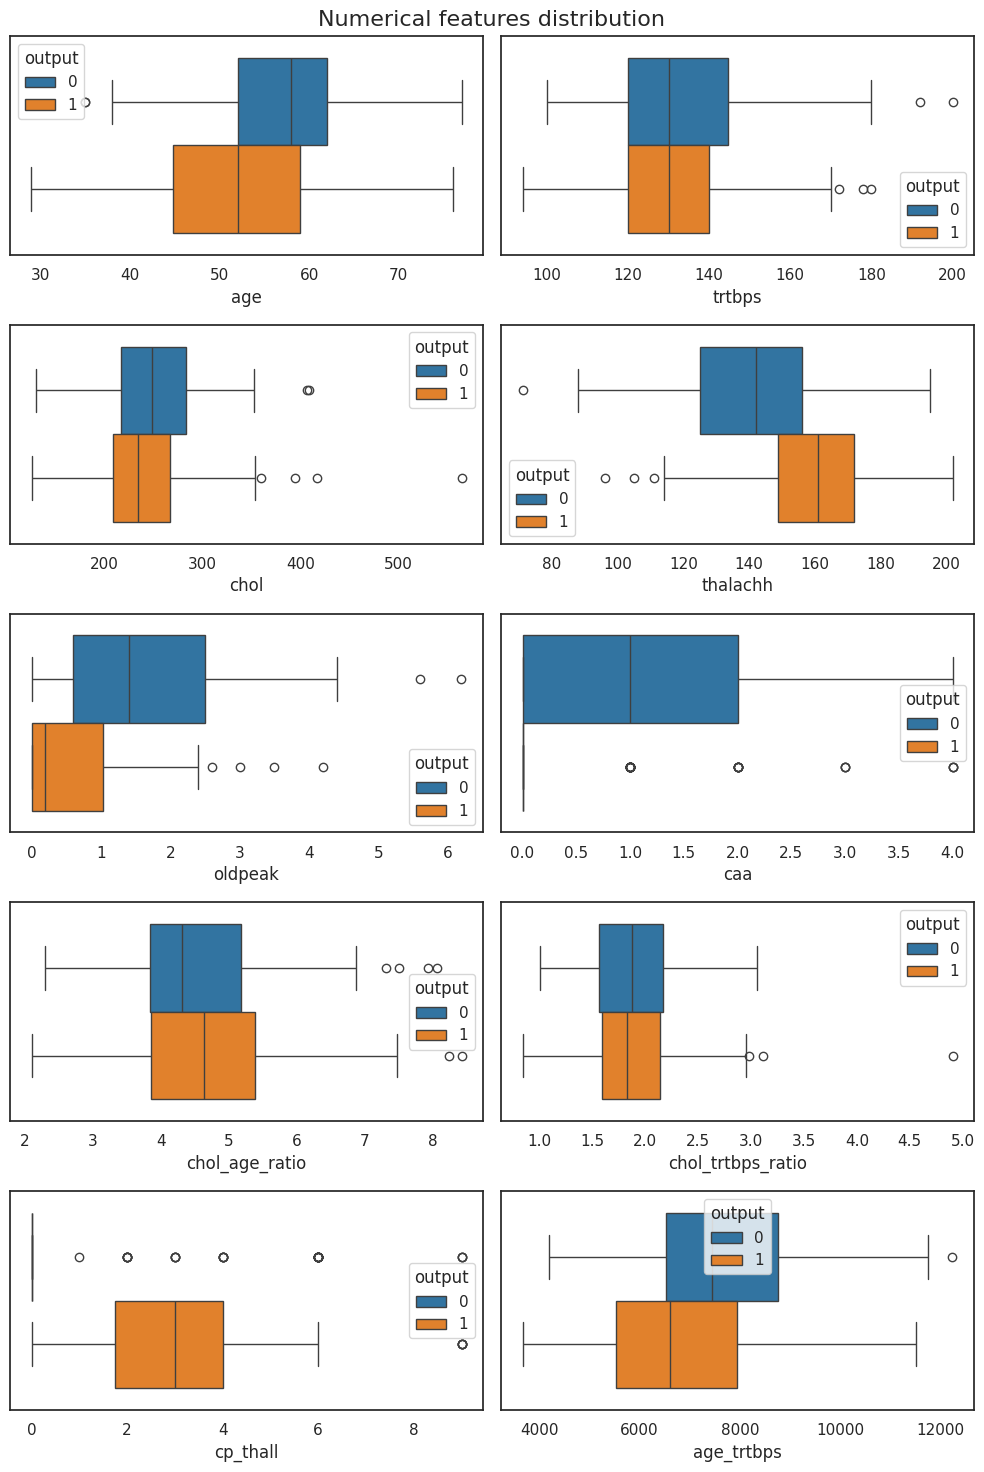

In [9]:
ncols = 2
nrows = int(np.ceil(len(numerical_features) / ncols))
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, nrows*3))
for feat, ax in zip(numerical_features, axes.flatten()):
    sns.boxplot(df, x=feat, hue="output", ax=ax)
fig.suptitle("Numerical features distribution", fontsize=16)
fig.tight_layout()
plt.show()

### Outliers analysis
- `caa`: Looks like there are patients with risk of heart attack with more major blood vessels (caa). I think those are outliers since most of the unhealthy people have tops 1 major blood vessel.
- `chol_trtbps_ratio`: Looks like there's a patient with a really high cholesterol and/or low blood pressure. Might be an outlier.

In [10]:
df.loc[df["output"] == 1, "caa"].value_counts()

caa
0    130
1     21
2      7
3      3
4      3
Name: count, dtype: int64

In [11]:
print(df.shape)
df = df.loc[~((df["output"] == 1) & (df["caa"] > 1))].copy(deep=True)
df.reset_index(drop=True, inplace=True)
print(df.shape)

(302, 20)
(289, 20)


In [12]:
print(df.shape)
df = df.loc[df["chol_trtbps_ratio"] < 4].copy(deep=True)
print(df.shape)

(289, 20)
(288, 20)


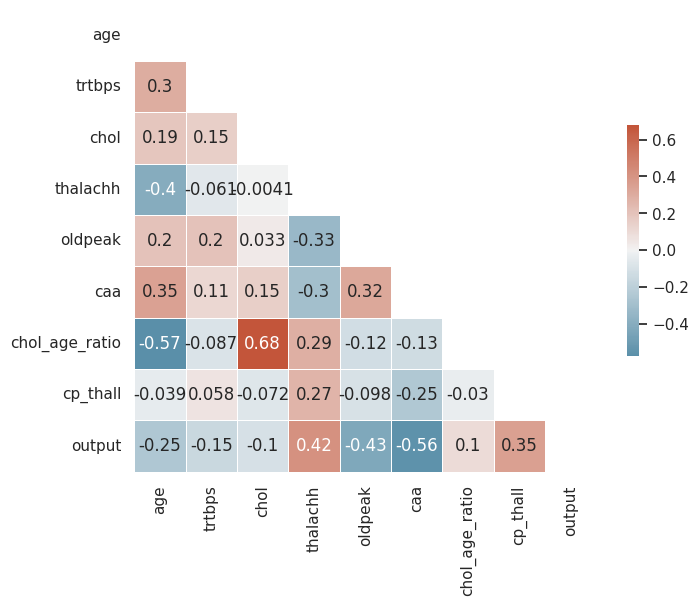

In [38]:
corr = df[numerical_features + ["output"]].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
fig, ax = plt.subplots(figsize=(8, 6))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
plt.show()

In [14]:
# Dropping highly correlated features
drop_features = ["age_trtbps", "chol_trtbps_ratio"]
numerical_features = [feat for feat in numerical_features if feat not in drop_features]

## Categorical features

### Nominal

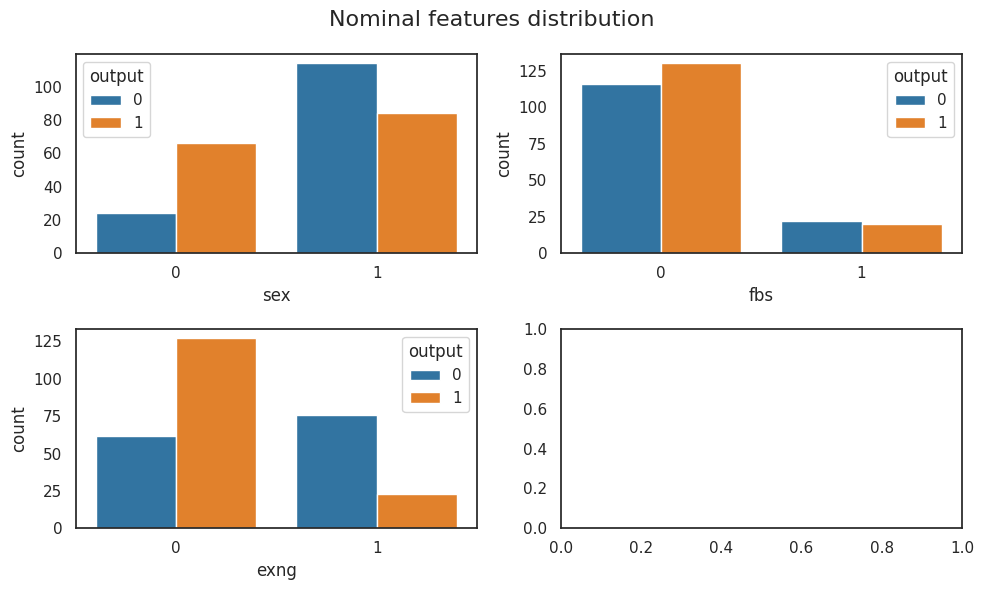

In [15]:
ncols = 2
nrows = int(np.ceil(len(nominal_features) / ncols))
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, nrows*3))
for feat, ax in zip(nominal_features, axes.flatten()):
    sns.countplot(df, x=feat, hue="output", ax=ax, stat="count")

fig.suptitle("Nominal features distribution", fontsize=16)
fig.tight_layout()
plt.show()

### Ordinal

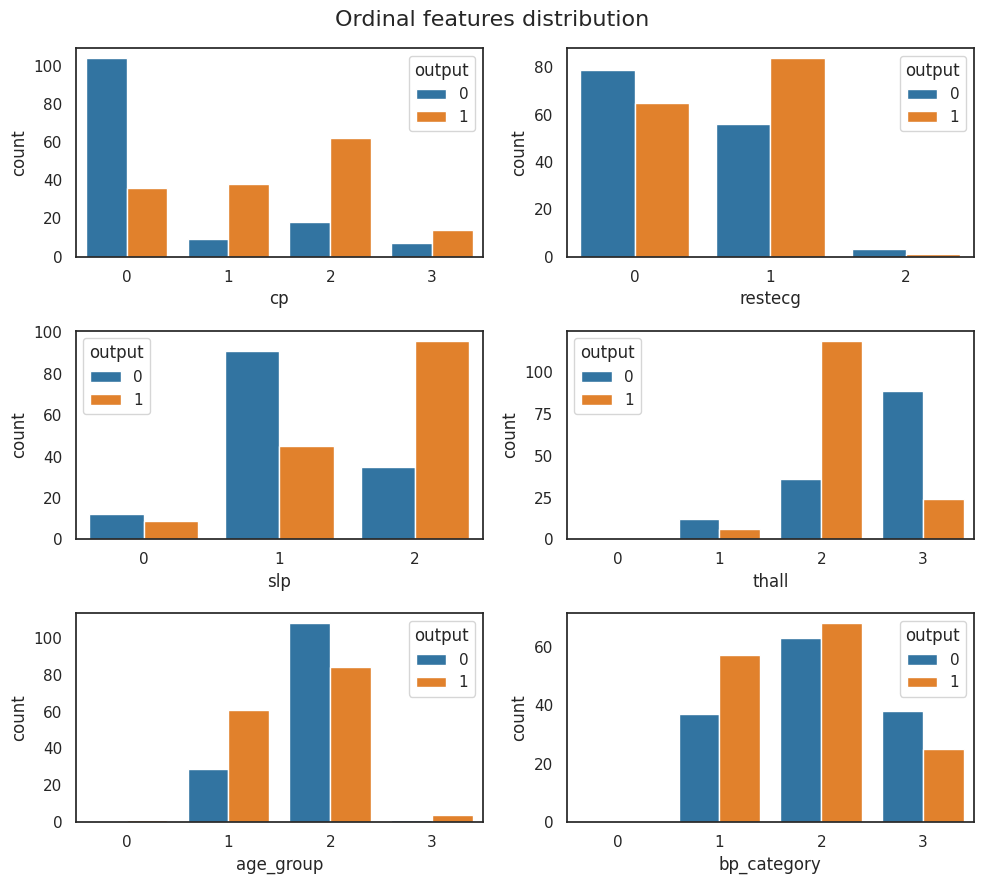

In [16]:
ncols = 2
nrows = int(np.ceil(len(ordinal_features) / ncols))
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, nrows*3))
for feat, ax in zip(ordinal_features, axes.flatten()):
    sns.countplot(df, x=feat, hue="output", ax=ax, stat="count")

fig.suptitle("Ordinal features distribution", fontsize=16)
fig.tight_layout()
plt.show()

`age_group`: Interestingly the age_group 1 which is ages between 30 and 50 are more likely to have heart problems.

## age_group vs numerical features

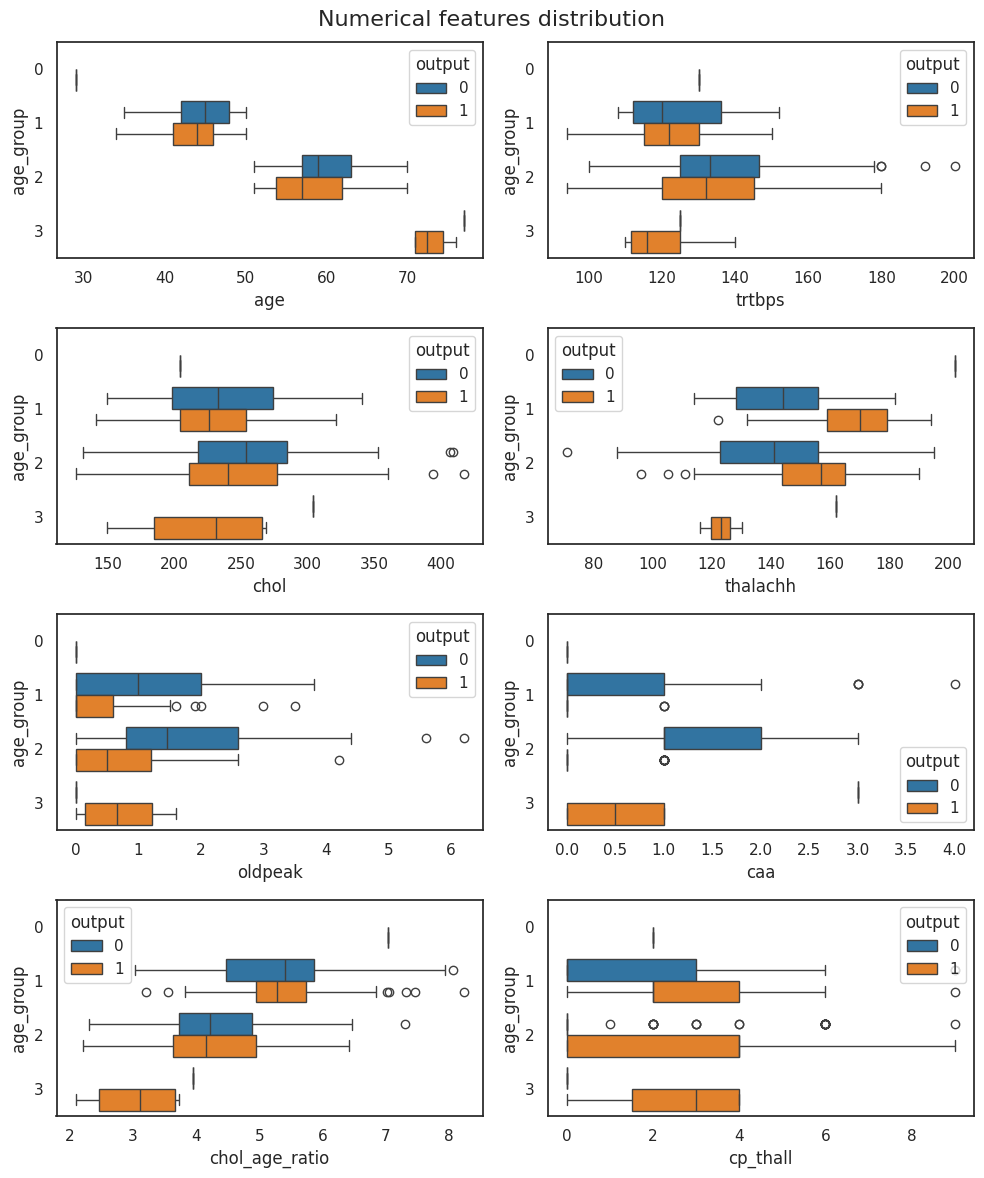

In [17]:
ncols = 2
nrows = int(np.ceil(len(numerical_features) / ncols))
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, nrows*3))
for feat, ax in zip(numerical_features, axes.flatten()):
    sns.boxplot(df, x=feat, y="age_group", hue="output", ax=ax)
fig.suptitle("Numerical features distribution", fontsize=16)
fig.tight_layout()
plt.show()

# Splitting into train and test datasets

In [18]:
df_train, df_test = train_test_split(df,
                                     test_size=0.2,
                                     random_state=42,
                                     stratify=df["output"].values)

# Preprocessing pipeline

In [19]:
categorical_features = nominal_features + ordinal_features
print(f"Numerical features: {numerical_features}")
print(f"Nominal features: {nominal_features}")
print(f"Ordinal features: {ordinal_features}")

Numerical features: ['age', 'trtbps', 'chol', 'thalachh', 'oldpeak', 'caa', 'chol_age_ratio', 'cp_thall']
Nominal features: ['sex', 'fbs', 'exng']
Ordinal features: ['cp', 'restecg', 'slp', 'thall', 'age_group', 'bp_category']


In [20]:
clf_pipe = Pipeline([
    ("features", FeatureUnion([
        ("numerical", Pipeline([
            ("selector", ColumnTransformer([("num", "passthrough", numerical_features)])),
            ("scaler", "passthrough")
        ])),
        ("categorical-nominal", Pipeline([
            ("selector", ColumnTransformer([("nom", "passthrough", nominal_features)])),
            ("encoder", "passthrough")
        ])),
        ("categorical-ordinal", Pipeline([
            ("selector", ColumnTransformer([("ord", "passthrough", ordinal_features)])),
            ("encoder", "passthrough")
        ]))
    ])),
    ("clf", None)
])

In [21]:
# Preprocessing
from sklearn.preprocessing import TargetEncoder, PowerTransformer, QuantileTransformer, RobustScaler, OneHotEncoder

# Models
from sklearn.linear_model import LogisticRegression, RidgeClassifier, PassiveAggressiveClassifier, Perceptron
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
# Boosting
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier


# Grid for testing all combinations
param_grid = {
    "features__numerical__scaler": ["passthrough",
                                    "drop",
                                    MinMaxScaler(), 
                                    StandardScaler(),
                                    PowerTransformer(), 
                                    QuantileTransformer(n_quantiles=100, random_state=42),
                                    RobustScaler()],
    "features__categorical-nominal__encoder": ["passthrough",
                                               "drop",
                                               OneHotEncoder(handle_unknown="ignore"),
                                               TargetEncoder(random_state=42)],
    "features__categorical-ordinal__encoder": ["passthrough", "drop"],
    "clf": [LogisticRegression(random_state=42, max_iter=1000),
            RidgeClassifier(random_state=42),
            LinearSVC(random_state=42),
            SVC(random_state=42),
            KNeighborsClassifier(), 
            GradientBoostingClassifier(random_state=42),
            Perceptron(random_state=42),
            PassiveAggressiveClassifier(random_state=42),
            DecisionTreeClassifier(random_state=42),
            RandomForestClassifier(random_state=42),
            AdaBoostClassifier(random_state=42, algorithm="SAMME"),
            BaggingClassifier(random_state=42),
            ExtraTreesClassifier(random_state=42),
            XGBClassifier(random_state=42),
            LGBMClassifier(random_state=42, verbose=-1),
            CatBoostClassifier(random_state=42, silent=True)]
}

In [22]:
%%time
# Disabling sklearn's forced warnings
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

from sklearn.model_selection import GridSearchCV, StratifiedKFold


cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(clf_pipe,
                           param_grid, 
                           scoring=["accuracy", "recall"], 
                           cv=cv, 
                           refit="accuracy") # Metric for assessing the best estimator
grid_search.fit(df, 
                df["output"].values)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('features',
                                        FeatureUnion(transformer_list=[('numerical',
                                                                        Pipeline(steps=[('selector',
                                                                                         ColumnTransformer(transformers=[('num',
                                                                                                                          'passthrough',
                                                                                                                          ['age',
                                                                                                                           'trtbps',
                                                                                                                           'chol',
                                                                                                                           'thalachh',
                                                                                                                           'oldpeak',
                                                                                                                           'caa',
                                                                                                                           'chol_age_ratio',
                                                                                                                           'cp_thall'])])),
                                                                                        ('scaler',
                                                                                         'passthrough')])),
                                                                       ('c...
                                                                    OneHotEncoder(handle_unknown='ignore'),
                                                                    TargetEncoder(random_state=42)],
                         'features__categorical-ordinal__encoder': ['passthrough',
                                                                    'drop'],
                         'features__numerical__scaler': ['passthrough', 'drop',
                                                         MinMaxScaler(),
                                                         StandardScaler(),
                                                         PowerTransformer(),
                                                         QuantileTransformer(n_quantiles=100,
                                                                             random_state=42),
                                                         RobustScaler()]},
             refit='accuracy', scoring=['accuracy', 'recall'])

In [29]:
pd.set_option("display.max_columns", 100)
cv_results = grid_search.cv_results_
df_results = pd.DataFrame(cv_results)
df_results.sort_values("mean_test_accuracy", ascending=False).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf,param_features__categorical-nominal__encoder,param_features__categorical-ordinal__encoder,param_features__numerical__scaler,params,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,split4_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,split0_test_recall,split1_test_recall,split2_test_recall,split3_test_recall,split4_test_recall,mean_test_recall,std_test_recall,rank_test_recall
0,0.057407,0.008525,0.004863,0.001635,"LogisticRegression(max_iter=1000, random_state...",passthrough,passthrough,passthrough,"{'clf': LogisticRegression(max_iter=1000, rand...",0.844828,0.879310,0.879310,0.877193,0.859649,0.868058,0.013763,1,0.833333,0.966667,0.866667,0.933333,0.900000,0.900000,0.047140,40
3,0.006638,0.000191,0.003539,0.000063,"LogisticRegression(max_iter=1000, random_state...",passthrough,passthrough,StandardScaler(),"{'clf': LogisticRegression(max_iter=1000, rand...",0.862069,0.862069,0.896552,0.877193,0.842105,0.867998,0.018114,2,0.866667,0.933333,0.900000,0.933333,0.866667,0.900000,0.029814,41
6,0.007496,0.000597,0.003663,0.000531,"LogisticRegression(max_iter=1000, random_state...",passthrough,passthrough,RobustScaler(),"{'clf': LogisticRegression(max_iter=1000, rand...",0.862069,0.862069,0.896552,0.877193,0.842105,0.867998,0.018114,2,0.866667,0.933333,0.900000,0.966667,0.866667,0.906667,0.038873,29
714,0.061340,0.002814,0.007535,0.000499,ExtraTreesClassifier(random_state=42),TargetEncoder(random_state=42),passthrough,passthrough,"{'clf': ExtraTreesClassifier(random_state=42),...",0.827586,0.931034,0.879310,0.877193,0.824561,0.867937,0.039258,4,0.866667,0.966667,0.866667,0.900000,0.833333,0.886667,0.045216,60
720,0.061134,0.003753,0.007585,0.000788,ExtraTreesClassifier(random_state=42),TargetEncoder(random_state=42),passthrough,RobustScaler(),"{'clf': ExtraTreesClassifier(random_state=42),...",0.827586,0.931034,0.879310,0.877193,0.824561,0.867937,0.039258,4,0.866667,0.966667,0.866667,0.900000,0.833333,0.886667,0.045216,60


In [32]:
from sklearn.model_selection import cross_validate


best_model = deepcopy(grid_search.best_estimator_)
scores = cross_validate(best_model, X=df, y=df["output"].values, scoring="accuracy", cv=cv)["test_score"]
print(f"Mean CV Accuracy: {np.mean(scores):.4f} +/- {np.std(scores):.3f}")

Mean CV Accuracy: 0.8681 +/- 0.014


# Feature importances

## Permutation importance

Permutation importance is a method to assess the impact of a feature on the predictive performance of a model. The process involves measuring the change in a 'scoring' function (e.g., accuracy, mean squared error) when the values of a specified feature are randomly shuffled, thereby breaking the relationship between that feature and the target variable. The model's performance is recalculated after shuffling, and the difference in the scoring metric before and after shuffling indicates the importance of the feature.

This process is typically repeated for `n_repeats` to account for variability, and the results can be visualized using a boxplot, where the spread (or variation) of the scores reflects the sensitivity of the model to changes in that feature. Refer to sklearn's documentation on for more details [Reference](https://scikit-learn.org/stable/modules/permutation_importance.html#outline-of-the-permutation-importance-algorithm).

Permutation importance <u>helps identify the most and least influential features in the model</u>. Features with low importance may be considered for exclusion, especially if they do not contribute significantly to the model's performance.

In [35]:
from sklearn.model_selection import train_test_split


# Training once more the model without cv
df_train, df_test = train_test_split(df,
                                     test_size=0.2,
                                     shuffle=True,
                                     random_state=42,
                                     stratify=df["output"].values)
best_model.fit(df_train,
               df_train["output"].values);

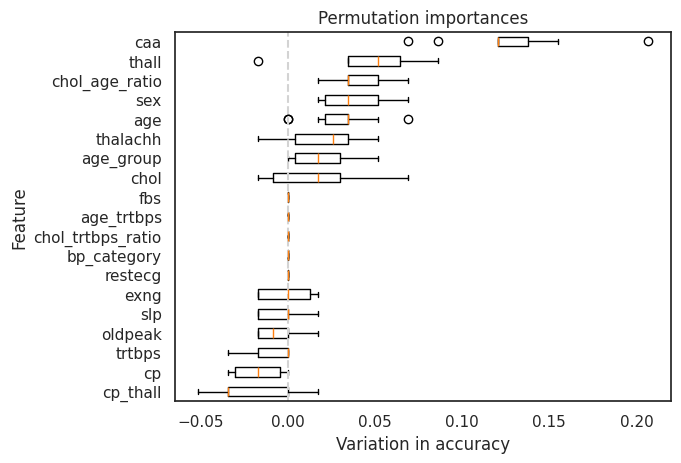

In [37]:
from sklearn.inspection import permutation_importance


# Calculating the model's importances
results = permutation_importance(best_model,
                                 # Dropping so it's not used for calculating the importances
                                 df_test.drop(columns="output"), 
                                 df_test["output"],
                                 scoring="accuracy",
                                 n_repeats=10,
                                 random_state=42)
feature_names = df_test.drop(columns="output").columns.values
importances = results["importances"]
order = np.argsort(results["importances_mean"])

fig, ax = plt.subplots()
ax.boxplot(results.importances[order].T,
           tick_labels=feature_names[order],
           vert=False)
ax.set_title("Permutation importances")
ax.set_xlabel("Variation in accuracy")
ax.set_ylabel("Feature")
ax.vlines(0, *ax.get_ylim(), colors="lightgrey", linestyles="dashed")
plt.show()

Key outputs:
- Looks like none of the numerical features impact the model's predictions as seen by "age", "trtbps", "oldpeak", "thalachh" and "chol" being below the plot with little variation in the test's accuracy score (+/- 2%).
- The features "cp" and "caa" are the most influential in the model's performance with a <u>decrease</u> in the model's score up to 12.5%.

### Excluding the least influential features

In [ ]:
# Preprocessing pipeline
numerical_features = ["age", "trtbps", "chol", "thalachh", "oldpeak"]
remainder_features = ["sex", "cp", "fbs", "restecg", "exng", "slp", "caa", "thall"]

features = Pipeline([
    ("features", FeatureUnion([
        ("numerical", Pipeline([
            # Only dropping the numerical features
            ("selector", ColumnTransformer([("num", "drop", numerical_features)])),
            # ("scaler", MinMaxScaler())
        ])),
        ("other-features", Pipeline([
            ("selector", ColumnTransformer([("rest", "passthrough", remainder_features)])),
            ("scaler", StandardScaler())
        ]))
    ]))
])

clf_pipe = Pipeline([
    ("features", features),
    ("clf", voting_clf)
])

In [ ]:
model_eval(clf_pipe)

In [ ]:
%%time
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# Run cross validation
cv_results = cross_validate(clf_pipe, 
                            X=df,
                            y=df["output"].values,
                            scoring="accuracy",
                            cv=cv)
# Return mean scores
print(f"CV Accuracy: {np.mean(cv_results['test_score']):.4f} +/- {np.std(cv_results['test_score']):.3f}")

Looks like excluding all numerical features increased the cv accuracy.

# Hyperparameter optimization

## Main objective function

Can be used as a decorator to decorate a model-specific function that returns an instance of classifier with the params set by optuna.

In [ ]:
from typing import Dict, Callable, Any
import optuna


# Setting logging to activate only for warnings or worse
optuna.logging.set_verbosity(optuna.logging.WARNING)

def objective(model_generator: Callable[[optuna.Trial], Any]) -> Callable[[optuna.Trial], float]:
    """
    A higher-order function that generates an Optuna objective function for hyperparameter optimization.

    Args:
        model_generator (Callable[[optuna.Trial], Any]): A function that takes an Optuna trial and returns an instantiated model.

    Returns:
        Callable[[optuna.Trial], float]: An Optuna objective function that returns the mean cross-validation accuracy.
    """
    def objective_function(trial: optuna.Trial) -> float:
        # Cross-validation setup
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        
        # Generate model with parameters from the trial
        model = model_generator(trial)
        
        # Run cross-validation
        cv_results = cross_validate(model, 
                                    X=df,
                                    y=df["output"].values, # Target column
                                    scoring="accuracy",
                                    cv=cv)
        # Return mean cross-validation accuracy
        return np.mean(cv_results["test_score"])
    
    return objective_function

## KNN

In [ ]:
@objective
def knn_objective(trial: optuna.Trial) -> Any:
    """
    Generates a KNeighborsClassifier with hyperparameters selected via Optuna trial.

    Args:
        trial (optuna.Trial): An Optuna trial object that suggests hyperparameters.

    Returns:
        Any: A pipeline model with KNeighborsClassifier set as the classifier.
    """
    params = {
        "n_neighbors": trial.suggest_int("n_neighbors", 1, 41, step=2),
        "weights": trial.suggest_categorical("weights", ["uniform", "distance"]),
        "algorithm": trial.suggest_categorical("algorithm", ["auto", "ball_tree", "kd_tree", "brute"]),
        "leaf_size": trial.suggest_int("leaf_size", 10, 100),
        "p": trial.suggest_int("p", 1, 2)  # 1 for Manhattan distance, 2 for Euclidean distance
    }
    
    # Setting the pipeline's params
    clf_pipe.set_params(clf=KNeighborsClassifier(**params))
    return clf_pipe

In [ ]:
%%time
from tqdm.auto import tqdm


# Creating a new study
knn_study = optuna.create_study(direction="maximize")
# Running the study
n_trials = 50
with tqdm(total=n_trials, desc="Optimizing") as pbar:
    knn_study.optimize(knn_objective, 
                       n_trials=n_trials,
                       callbacks=[lambda study, trial: pbar.update(1), 
                                  lambda study, trial: pbar.set_description(f"Best Trial: {study.best_trial.number} - Score: {study.best_trial.value:.4f}")])

In [ ]:
best_trial = knn_study.best_trial
print(f"Best Trial: {best_trial.number} - Accuracy: {best_trial.value:.4f}")
best_knn_params = best_trial.params
best_knn_params

## SVM

In [ ]:
@objective
def svm_objective(trial: optuna.Trial) -> Any:
    """
    Generates a SVC with hyperparameters selected via Optuna trial.

    Args:
        trial (optuna.Trial): An Optuna trial object that suggests hyperparameters.

    Returns:
        Any: A pipeline model with SVC set as the classifier.
    """
    kernel = trial.suggest_categorical("kernel", ["linear", "poly", "rbf", "sigmoid"])
    # Suggest other hyperparameters based on the kernel
    params = {
        "C": trial.suggest_float("C", 1e-6, 1e3, log=True),
        "kernel": kernel,
        "gamma": trial.suggest_categorical("gamma", ["scale", "auto"])
    }
    # Conditionally suggest 'degree' only if kernel is 'poly'
    if kernel == "poly":
        params["degree"] = trial.suggest_int("degree", 2, 5)
    # Conditionally suggest 'coef0' only if kernel is 'poly' or 'sigmoid'
    if kernel in ["poly", "sigmoid"]:
        params["coef0"] = trial.suggest_float("coef0", 0.0, 10.0)
    
    # Setting the pipeline's params
    clf_pipe.set_params(clf=SVC(**params, random_state=42))
    return clf_pipe

In [ ]:
%%time
# Creating a new study
svm_study = optuna.create_study(direction="maximize")
# Running the study
n_trials = 50
with tqdm(total=n_trials, desc="Optimizing") as pbar:
    svm_study.optimize(svm_objective, 
                       n_trials=n_trials,
                       callbacks=[lambda study, trial: pbar.update(1), 
                                  lambda study, trial: pbar.set_description(f"Best Trial: {study.best_trial.number} - Score: {study.best_trial.value:.4f}")])

In [ ]:
best_trial = svm_study.best_trial
print(f"Best Trial: {best_trial.number} - Accuracy: {best_trial.value:.4f}")
best_svm_params = best_trial.params
best_svm_params

## Catboost

Taken from: [Reference](https://www.kaggle.com/code/baekseungyun/catboost-hyper-parameter-tuning-with-optuna)

In [ ]:
def catboost_objective(trial: optuna.Trial) -> Any:
    """
    Generates a CatBoostClassifier with hyperparameters selected via Optuna trial.

    Args:
        trial (optuna.Trial): An Optuna trial object that suggests hyperparameters.

    Returns:
        Any: A pipeline model with CatBoostClassifier set as the classifier.
    """
    params = {
        "iterations": 500,
        "learning_rate": trial.suggest_float("learning_rate", 0.1, 1.0, log=True),
        "l2_leaf_reg": trial.suggest_int("l2_leaf_reg", 1, 100, log=True),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.1, 20.0, log=True),
        "random_strength": trial.suggest_float("random_strength", 1.0, 2.0),
        "depth": trial.suggest_int("depth", 1, 10),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 300),
        "use_best_model": True
    }
        
    # Setting the pipeline's params
    preprocess_pipe = clf_pipe.named_steps["features"]
    model = CatBoostClassifier(random_state=42, verbose=0, **params)
    
    # Cross validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # Cross validation by hand
    cv_scores = []
    for fold_idx, (train_idx, test_idx) in enumerate(cv.split(df, df["output"].values)):
        # Applying the preprocess
        X_train = preprocess_pipe.fit_transform(df.loc[train_idx.flatten()])
        X_test = preprocess_pipe.transform(df.loc[test_idx.flatten()])
        # Targets
        y_train = df.loc[train_idx.flatten(), "output"].values
        y_test = df.loc[test_idx.flatten(), "output"].values

        # Train catboost
        model.fit(X_train, 
                  y_train, 
                  eval_set=(X_test, y_test),
                  verbose=False,
                  early_stopping_rounds=100)
        
        # Calculate fold's score
        y_pred = model.predict(X_test)
        fold_score = accuracy_score(y_test, y_pred)
        cv_scores.append(fold_score)
    return np.mean(cv_scores)

In [ ]:
%%time
# Creating a new study
catboost_study = optuna.create_study(direction="maximize", 
                                     pruner=optuna.pruners.MedianPruner())
# Running the study
n_trials = 50
with tqdm(total=n_trials, desc="Optimizing") as pbar:
    catboost_study.optimize(catboost_objective, 
                       n_trials=n_trials,
                       callbacks=[lambda study, trial: pbar.update(1), 
                                  lambda study, trial: pbar.set_description(f"Best Trial: {study.best_trial.number} - Score: {study.best_trial.value:.4f}")])

In [ ]:
best_trial = catboost_study.best_trial
print(f"Best Trial: {best_trial.number} - Accuracy: {best_trial.value:.4f}")
best_catboost_params = best_trial.params
best_catboost_params

## Optimized voting classifier

In [ ]:
%%time
# Setting best params
voting_clf = VotingClassifier(estimators=[
        ("knn", KNeighborsClassifier(**best_knn_params)),
        ("svm", SVC(random_state=42,
                    **best_svm_params)),
        ("catboost", CatBoostClassifier(random_state=42,
                                verbose=0, 
                                **best_catboost_params))
])

clf_pipe.set_params(clf=voting_clf)
model_eval(clf_pipe)

In [ ]:
%%time
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# Run cross validation
cv_results = cross_validate(clf_pipe, 
                            X=df,
                            y=df["output"].values,
                            scoring="accuracy",
                            cv=cv)
# Return mean scores
print(f"CV Accuracy: {np.mean(cv_results['test_score']):.4f} +/- {np.std(cv_results['test_score']):.3f}")

# Explaining the final model

## Partial Dependency Plot

Partial dependency plots (PDPs) are used to explain <u>how a feature affects the model's predictions on average</u>. Unlike permutation importance, which assesses the impact of a feature on the model's overall performance, PDPs illustrate the relationship between a specific feature and the model's predictions by showing how the predictions change as the feature's values vary, while all other features are held constant.

The process to create a partial dependency plot involves the following steps:
- Select a feature and determine its minimum and maximum values.
- Generate a range of values within the minimum and maximum limits of the selected feature.
- For each value in this range, replace the corresponding feature values of all instances in the dataset with the current value.
- Use the model to generate predictions for these modified instances and calculate the mean prediction (expected value) for each feature value.

This process results in an array with a range of values for the selected feature (X-axis) and the corresponding average predictions of the model, denoted as $(E[f(x)])$, for each feature value (Y-axis).

In [ ]:
import math
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from typing import Callable, Optional, Iterable


def plot_pdp(feature_name: str,
             predict_func: Callable,
             data: pd.DataFrame,
             npoints: int=150) -> None:
    """
    Plots a Partial Dependence Plot (PDP) for the feature at the given index.
    """
    min_, max_ = data[feature_name].min(), data[feature_name].max()
    # Generating synthetic values for the feature given the range
    std = np.std(data[feature_name])
    # Adding 1 std each side to broaden the feature range
    feature_values = np.linspace(min_ - std, max_ + std, num=npoints)
    # Getting the model's predictions and computing the average of
    # predictions for each value of the selected feature
    mean_predictions = []
    copy_data = data.copy()
    for val in feature_values:
        # Swapping the feature values on all instances by
        # the generated value
        copy_data[feature_name] = val
        # Calculate the model's outputs
        model_predictions = predict_func(copy_data)
        # Calculate the mean and store
        mean_predictions.append(model_predictions.mean())

    # Calculating the model expected value
    expected_value = np.mean(mean_predictions)
    feature_expected_value = np.mean(feature_values)

    # PLotting
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    # pdp
    pdp = go.Scatter(x=feature_values, 
                     y=mean_predictions, 
                     name="Model Expected Value", 
                     hovertemplate=
                     "Mean Preds.: %{y:.2f}<br>" + 
                     f"{feature_name}" + ": %{x:,.2f}")
    fig.add_trace(pdp)
    fig.update_yaxes(range=[min(mean_predictions),
                            max(mean_predictions)],
                     secondary_y=False)
    # Histogram with actual data
    hist = go.Histogram(x=data[feature_name],
                        name=feature_name,
                        histnorm="probability",
                        opacity=0.6,
                        hovertemplate=
                        f"{feature_name}: " + "%{x:,.2f}<br>" +
                        "Prob.: %{y:.3f}")
    fig.add_trace(hist, secondary_y=True)
    # Adjust secondary yaxis
    fig.update_yaxes(range=[0, 1.0], 
                     secondary_y=True,
                     showticklabels=False) # Hide yaxis
    
    # Adding the mean expected value and feature expected value
    fig.add_hline(y=expected_value,
                  line_width=1,
                  line_dash="dash",
                  annotation_text="E[f(x)]", 
                  annotation_position="top right")
    fig.add_vline(x=feature_expected_value,
                  line_width=1,
                  line_dash="dash",
                  annotation_text=f"E[{feature_name}]",
                  annotation_position="top right")
    
    # Change figure size
    fig.update_layout(title="Partial Dependence Plot",
                      height=600,
                      width=800, 
                      plot_bgcolor="white")
    fig.update_yaxes(title=f"E[f(x)|{feature_name}]",
                     secondary_y=False)
    fig.update_xaxes(title=feature_name)
    fig.show()
    
        
plot_pdp("chol", 
         clf_pipe.predict,
         df_test)

### Plot using shap package

In [ ]:
import shap


shap.partial_dependence_plot(
    "chol",
    clf_pipe.predict,
    df_test,
    ice=False,
    model_expected_value=True,
    feature_expected_value=True,
)

## SHAP Values

SHAP (SHapley Additive exPlanations) values provide a way to interpret the output of a machine learning model by assigning each feature an importance value for a particular prediction. Unlike permutation importance, which evaluates the effect of shuffling a feature on model performance, and partial dependency plots, which show the average effect of a feature across all instances, SHAP values explain how much each feature contributes to a single prediction.

SHAP values are based on cooperative game theory and provide a fair allocation of feature contributions by considering all possible combinations of features. This method gives insights into which features are driving the predictions and whether their impact is positive or negative.

Comparison:
- **Permutation Importance**: Measures how much the model's performance changes when a feature is shuffled, giving a global sense of feature importance.
- **Partial Dependency Plots**: Show how the model's predictions change as the value of one feature varies, averaged across all instances.
- **SHAP Values**: Offer a detailed explanation for each prediction by quantifying the contribution of each feature, making it a powerful tool for understanding individual predictions.

In [ ]:
%%time
explainer = shap.Explainer(clf_pipe.predict,
                           df_test,
                           feature_names=feature_names)

shap_values = explainer(df_test)
shap_values.shape

In [ ]:
import plotly.express as px


def plot_summary_plot(shap_values: shap.Explainer,
                      feature_names: Iterable[str], 
                      index: Optional[pd.Index]=None):
    """
    Plots a summary plot which displays each data
    point individual feature contribution to the
    predicted output and if the feature value is
    high or low.
    """
    n_instances = len(shap_values.values)
    # From least to most influential feature
    order = np.abs(shap_values.values).mean(axis=0).argsort()
    ordered_feature_names = feature_names[order]
    
    # Manipulating the SHAP results to recreate a plot data
    shap_df = pd.DataFrame(shap_values.values, columns=feature_names, index=index)
    # Stacking the columns into a sigle column
    shap_df = shap_df.stack().to_frame("shap_value")
    shap_df.index.rename(["id", "feature"], inplace=True)
    # Actual feature values
    data_df = pd.DataFrame(shap_values.data, columns=feature_names, index=index).stack().to_frame("feature_value")
    data_df.index.rename(["id", "feature"], inplace=True)
    # Joining the data
    shap_df = pd.merge(left=shap_df, 
                       right=data_df,
                       left_index=True,
                       right_index=True,
                       how="inner",
                       validate="one_to_one").reset_index(drop=False)
    
    # Finding if a feature value is high or low
    # In order to assess different scaled features I'll min max it
    # so every feature is in the range 0 to 1
    minmax_df = data_df.groupby("feature").agg(feature_min=("feature_value", "min"),
                                               feature_max=("feature_value", "max")).reset_index()
    shap_df = pd.merge(left=shap_df, 
                       right=minmax_df,
                       left_on="feature",
                       right_on="feature",
                       how="inner",
                       validate="many_to_one")
    # Normalizing
    shap_df["feature_value_norm"] = np.round((shap_df["feature_value"] - shap_df["feature_min"]) / (shap_df["feature_max"] - shap_df["feature_min"]), 1)

    # The actual plot
    fig = make_subplots()
    # Loop through each feature
    for i, feature in enumerate(ordered_feature_names, start=1):
        marker = dict(
            color=shap_df.loc[shap_df["feature"] == feature, "feature_value_norm"],
            colorscale="BlueRed",
            showscale=True if i == 1 else False,
            colorbar={
                "title": "Feature Value",
                "tickvals": [0.0, 1.0], 
                "ticktext": ["Low", "High"]}
        )
        trace = go.Scatter(x=shap_df.loc[shap_df["feature"] == feature, "shap_value"],
                           # Just positioning the feature and 
                           # adding "noise" to unstack the datapoints
                           # simulating a 'strip' plot
                           y=i + np.random.randn(n_instances) * 0.1,
                           name="",
                           mode="markers",
                           marker=marker,
                           customdata=shap_df.loc[shap_df["feature"] == feature, ["id", "feature_value"]],
                           hovertemplate=
                           "ID: %{customdata[0]}<br>" +
                           f"{feature}: " + "%{customdata[1]}<br>" + 
                           "SHAP: %{x:.3f}")
        fig.add_trace(trace)
        
    fig.update_xaxes(title="SHAP Value (impact on model prediction)")
    # Adding yaxis feature names
    fig.update_yaxes(tickvals=np.linspace(1., len(ordered_feature_names), num=len(ordered_feature_names)),
                     ticktext=ordered_feature_names)
    # Adding title and reshaping the plot
    fig.update_layout(title="Features contributions",
                      height=600,
                      width=800,
                      showlegend=False, 
                      plot_bgcolor="white")
    fig.add_vline(x=0, line_width=1)
    fig.show()


plot_summary_plot(shap_values,
                  feature_names, 
                  index=df_test.index)

### Built-in summary plot

The drawback is that you can't display custom data like the actual feature value for each datapoint.

In [ ]:
shap.summary_plot(shap_values, 
                  feature_names=feature_names)

## Explaining the predictions for an instance 

In [ ]:
%%time
instance = df_test.sample(1, random_state=42)
shap_instance = explainer(instance)
shap_instance

In [ ]:
def plot_individual_contribution(shap_values,
                                 feature_names,
                                 predicted_label: Optional[str]=None):
    """
    """
    plot_data = pd.DataFrame(shap_values.values, columns=feature_names).stack().to_frame("shap_value").sort_values("shap_value")
    plot_data.index.rename(["id", "feature"], inplace=True)
    plot_data.reset_index(inplace=True)
    
    fig = make_subplots()
    
    fig.add_trace(go.Bar(
        x=plot_data["shap_value"],
        y=plot_data["feature"],
        orientation="h"
    ))
    fig.update_xaxes(title="SHAP Value (impact on model prediction)")
    # Adding title and reshaping the plot
    fig.update_layout(title="Individual Explanation",
                      height=500,
                      width=600,
                      showlegend=False,
                      plot_bgcolor="white")
    fig.add_annotation(
        x=-0.10, 
        y=1.1,
        xref="paper",
        yref="paper",
        showarrow=False,
        text="" if not predicted_label else f"Prediction: {predicted_label}")
    fig.show()

actual_label = str(y_test[np.where(df_test.index.values == instance.index[0])[0][0]])
predicted_label = str(clf_pipe.predict(instance)[0])
plot_individual_contribution(shap_instance, feature_names)